In [1]:
library(OmnipathR)
# library(nichenetr)
library(tidyverse)
library(dplyr)
library(VennDiagram)
library(ggplot2)
library(utils)
library(glue)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.4      ✔ purrr   0.3.5 
✔ tibble  3.2.1      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: grid

Loading required package: futile.logger



```import_ligrecextra_interactions```

link: to documentation <https://r.omnipathdb.org/reference/import_ligrecextra_interactions.html>

This LR dataset contains ligand-receptor interactions without literature reference. The ligand-receptor interactions supported by literature references are part of the `omnipath` dataset.


Default params(without filtering resources) have 8350 edges. The table includes columns as follows. 

'source' 'target' 'source_genesymbol' 'target_genesymbol' 'is_directed' 'is_stimulation' 'is_inhibition' 'consensus_direction' 'consensus_stimulation' 'consensus_inhibition' 'sources' 'references' 'curation_effort' 'n_references' 'n_resources'

**The consensus score is if resources support the classification of an entity into a category based on combined information of many resources.**

| sources                                                         | ref | cur_effort | n_ref | n_source |
|-----------------------------------------------------------------|-----|------------|-------|----------|
|      Baccin2019;CellCall;PhosphoPoint;Ramilowski2015_Baccin2019 | NA  | 0          | 0     | 3        |
| Baccin2019;CellCall;PhosphoPoint;Ramilowski2015_Baccin2019;Wang | NA  | 0          | 0     | 4        |
|                                                                 |     |            |       |          |

```curated_ligand_receptor_interactions```

expert curated ligand-receptor resources, provided by this function




# change LR to non-curated

In [2]:
# https://r.omnipathdb.org/reference/curated_ligand_receptor_interactions.html
# curated=curated_ligand_receptor_interactions()
non_curated <- import_ligrecextra_interactions()
non_curated <- non_curated %>% filter(!duplicated(non_curated[, c("source_genesymbol", "target_genesymbol")]))
non_curated$pair <- paste(non_curated$source_genesymbol, non_curated$target_genesymbol,sep="_")
non_curated$annotation_strategy <- "LR"


curated <- curated_ligand_receptor_interactions()
curated <- curated %>% filter(!duplicated(curated[, c("source_genesymbol", "target_genesymbol")]))
curated$pair <- paste(curated$source_genesymbol, curated$target_genesymbol,sep="_")
curated$annotation_strategy <- "curated"

In [3]:
# if pair is also in curatedDB, annotation_strategy should be both
non_curated <- non_curated %>%
      mutate(annotation_strategy = ifelse(pair %in% curated$pair, "both", annotation_strategy))

In [4]:
both_db <- rbind(non_curated,curated)
both_db <- both_db[!duplicated(both_db$pair), ]

In [5]:
table(both_db$annotation_strategy)


   both curated      LR 
   4955     102    3278 

In [6]:
anno_raw <- import_omnipath_intercell()
#subset annotation DB to only ligand and receptors
anno_lig <- anno_raw %>%
    dplyr::filter(category %in% c("receptor","ligand"))
# Drop rows where the values in the "parent", "database", and "uniprot" columns are duplicated
anno_raw <- anno_raw %>% filter(!duplicated(anno_raw[, c("parent", "database", "uniprot")]))

# Breaking down complexes

Below, we produce all the the possible pairs. 

Example: lets assume complex G1_G2_G3 is linked to another complex G4_G5_G6

| c1 | c2 | complex_origin    |
|----|----|-------------------|
| G1 | G2 | G1_G2_G3_G4_G5_G6 |
| G1 | G3 | G1_G2_G3_G4_G5_G6 |
| G1 | G4 | G1_G2_G3_G4_G5_G6 |
| G1 | G5 | G1_G2_G3_G4_G5_G6 |
| G1 | G6 | G1_G2_G3_G4_G5_G6 |
| G2 | G1 | G1_G2_G3_G4_G5_G6 |
| G2 | G3 | G1_G2_G3_G4_G5_G6 |
| .. | .. | G1_G2_G3_G4_G5_G6 |

In [7]:
# Function to generate pairwise pairs from a complex data frame
create_pairwise_pairs <- function(complex) {
    results <- data.frame() # Initialize an empty data frame to store results

    # Loop through each row of the complex data frame
    for (i in 1:nrow(complex)) {
        # Split the source and target gene symbols and store as separate variables
        values1 <- unlist(strsplit(as.character(complex[i, "source_genesymbol"]), "_"))
        values2 <- unlist(strsplit(as.character(complex[i, "target_genesymbol"]), "_"))

        # Store the original pair as a string
        original <- paste(complex[i, "source_genesymbol"], complex[i, "target_genesymbol"], sep = "_")

        # Generate all possible pairwise combinations
        pairs <- combn(c(values1, values2), 2)
        pairs <- t(pairs) # Transpose the matrix to get pairs in rows

        # Switch values in columns and append to pairs
        pairs <- rbind(pairs, pairs[, 2:1])
        
        # Add the original complex pair as a new column
        pairs <- cbind(pairs, original)

        # Set column names for the pairs data frame
        colnames(pairs) <- c("Ligand", "Receptor", "complex_pair")

        # Append the current row of the complex data frame to the pairs
        pairs <- cbind(pairs, complex[i,])

        # Bind the pairs data frame to the results
        results <- rbind(results, pairs)
    }

    # Create a new Pair.Name column and position it as the first column
    results$Pair.Name <- paste(results$Ligand, results$Receptor, sep = "_")
    results <- data.frame(Pair.Name = results$Pair.Name, results[, !(names(results) %in% "Pair.Name")])

    # Return the final results data frame
    return(results)
}


In [8]:
complex <- filter(both_db, grepl("COMPLEX", target) | grepl("COMPLEX", source))

In [9]:
# remove pair column
complex$pair <- NULL

In [10]:
pairwise_pairs <- create_pairwise_pairs(complex)

In [11]:
length(unique(pairwise_pairs$Pair.Name))

[1] 3272

In [12]:
filter(pairwise_pairs, complex_pair=="IL17A_IL17RA_IL17RC")

Pair.Name,Ligand,Receptor,complex_pair,source,target,source_genesymbol,target_genesymbol,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>
IL17A_IL17RA,IL17A,IL17RA,IL17A_IL17RA_IL17RC,Q16552,COMPLEX:Q8NAC3_Q96F46,IL17A,IL17RA_IL17RC,1,1,0,1,1,0,CellChatDB;CellPhoneDB;Cellinker;ICELLNET;SIGNOR,Cellinker:19838198;Cellinker:25204502;Cellinker:9367539;ICELLNET:24011563;SIGNOR:32024054,5,5,5,both
IL17A_IL17RC,IL17A,IL17RC,IL17A_IL17RA_IL17RC,Q16552,COMPLEX:Q8NAC3_Q96F46,IL17A,IL17RA_IL17RC,1,1,0,1,1,0,CellChatDB;CellPhoneDB;Cellinker;ICELLNET;SIGNOR,Cellinker:19838198;Cellinker:25204502;Cellinker:9367539;ICELLNET:24011563;SIGNOR:32024054,5,5,5,both
IL17RA_IL17RC,IL17RA,IL17RC,IL17A_IL17RA_IL17RC,Q16552,COMPLEX:Q8NAC3_Q96F46,IL17A,IL17RA_IL17RC,1,1,0,1,1,0,CellChatDB;CellPhoneDB;Cellinker;ICELLNET;SIGNOR,Cellinker:19838198;Cellinker:25204502;Cellinker:9367539;ICELLNET:24011563;SIGNOR:32024054,5,5,5,both
IL17RA_IL17A,IL17RA,IL17A,IL17A_IL17RA_IL17RC,Q16552,COMPLEX:Q8NAC3_Q96F46,IL17A,IL17RA_IL17RC,1,1,0,1,1,0,CellChatDB;CellPhoneDB;Cellinker;ICELLNET;SIGNOR,Cellinker:19838198;Cellinker:25204502;Cellinker:9367539;ICELLNET:24011563;SIGNOR:32024054,5,5,5,both
IL17RC_IL17A,IL17RC,IL17A,IL17A_IL17RA_IL17RC,Q16552,COMPLEX:Q8NAC3_Q96F46,IL17A,IL17RA_IL17RC,1,1,0,1,1,0,CellChatDB;CellPhoneDB;Cellinker;ICELLNET;SIGNOR,Cellinker:19838198;Cellinker:25204502;Cellinker:9367539;ICELLNET:24011563;SIGNOR:32024054,5,5,5,both
IL17RC_IL17RA,IL17RC,IL17RA,IL17A_IL17RA_IL17RC,Q16552,COMPLEX:Q8NAC3_Q96F46,IL17A,IL17RA_IL17RC,1,1,0,1,1,0,CellChatDB;CellPhoneDB;Cellinker;ICELLNET;SIGNOR,Cellinker:19838198;Cellinker:25204502;Cellinker:9367539;ICELLNET:24011563;SIGNOR:32024054,5,5,5,both


# Linking through PPI

We are using the Omnipath intercellular interaction network, which is the largest available network of its kind, to detect interactions rather than make predictions. The creators of the network have noted that it may contain a large number of false positives. Despite this, we are using it in combination with an annotations database to detect interactions. The network has a size of 98,165 edges.

In [13]:
# Import All PPI
pt <- import_post_translational_interactions()

In [14]:
ppi_network <- pt %>% filter(!duplicated(pt[, c("source_genesymbol", "target_genesymbol")]))

In [15]:
# create pairs, so its easier to check
ppi_network$Pair.Name=paste(ppi_network$source_genesymbol, ppi_network$target_genesymbol,sep="_")

In [16]:
#drop duplicates
pairwise_pairs <- pairwise_pairs[!duplicated(pairwise_pairs$Pair.Name),]

In [17]:
# The data frame result_df consists of all the pairwise pair combinations, 
# and we are checking if those pairs exist in the PT network
pt_interactions <- pairwise_pairs %>%
    filter(Pair.Name %in% ppi_network$Pair.Name)

str(pt_interactions)

'data.frame':	1262 obs. of  20 variables:
 $ Pair.Name            : chr  "IL17A_IL17RA" "IL17A_IL17RC" "IL17RA_IL17A" "NPNT_ITGA8" ...
 $ Ligand               : chr  "IL17A" "IL17A" "IL17RA" "NPNT" ...
 $ Receptor             : chr  "IL17RA" "IL17RC" "IL17A" "ITGA8" ...
 $ complex_pair         : chr  "IL17A_IL17RA_IL17RC" "IL17A_IL17RA_IL17RC" "IL17A_IL17RA_IL17RC" "NPNT_ITGA8_ITGB1" ...
 $ source               : chr  "Q16552" "Q16552" "Q16552" "Q6UXI9" ...
 $ target               : chr  "COMPLEX:Q8NAC3_Q96F46" "COMPLEX:Q8NAC3_Q96F46" "COMPLEX:Q8NAC3_Q96F46" "COMPLEX:P05556_P53708" ...
 $ source_genesymbol    : chr  "IL17A" "IL17A" "IL17A" "NPNT" ...
 $ target_genesymbol    : chr  "IL17RA_IL17RC" "IL17RA_IL17RC" "IL17RA_IL17RC" "ITGA8_ITGB1" ...
 $ is_directed          : num  1 1 1 1 1 1 1 1 1 1 ...
 $ is_stimulation       : num  1 1 1 1 1 1 1 1 1 1 ...
 $ is_inhibition        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ consensus_direction  : num  1 1 1 1 1 0 0 0 0 1 ...
 $ consensus_stimulation

In [18]:
glue("Number of non-redundant pairwise pairs: {nrow(pairwise_pairs)}, Number of pairs found in PPI: {nrow(pt_interactions)}")

Number of non-redundant pairwise pairs: 3272, Number of pairs found in PPI: 1262

In [19]:
filter(pairwise_pairs, complex_pair=="IL17A_IL17RA_IL17RC")

Pair.Name,Ligand,Receptor,complex_pair,source,target,source_genesymbol,target_genesymbol,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>
IL17A_IL17RA,IL17A,IL17RA,IL17A_IL17RA_IL17RC,Q16552,COMPLEX:Q8NAC3_Q96F46,IL17A,IL17RA_IL17RC,1,1,0,1,1,0,CellChatDB;CellPhoneDB;Cellinker;ICELLNET;SIGNOR,Cellinker:19838198;Cellinker:25204502;Cellinker:9367539;ICELLNET:24011563;SIGNOR:32024054,5,5,5,both
IL17A_IL17RC,IL17A,IL17RC,IL17A_IL17RA_IL17RC,Q16552,COMPLEX:Q8NAC3_Q96F46,IL17A,IL17RA_IL17RC,1,1,0,1,1,0,CellChatDB;CellPhoneDB;Cellinker;ICELLNET;SIGNOR,Cellinker:19838198;Cellinker:25204502;Cellinker:9367539;ICELLNET:24011563;SIGNOR:32024054,5,5,5,both
IL17RA_IL17RC,IL17RA,IL17RC,IL17A_IL17RA_IL17RC,Q16552,COMPLEX:Q8NAC3_Q96F46,IL17A,IL17RA_IL17RC,1,1,0,1,1,0,CellChatDB;CellPhoneDB;Cellinker;ICELLNET;SIGNOR,Cellinker:19838198;Cellinker:25204502;Cellinker:9367539;ICELLNET:24011563;SIGNOR:32024054,5,5,5,both
IL17RA_IL17A,IL17RA,IL17A,IL17A_IL17RA_IL17RC,Q16552,COMPLEX:Q8NAC3_Q96F46,IL17A,IL17RA_IL17RC,1,1,0,1,1,0,CellChatDB;CellPhoneDB;Cellinker;ICELLNET;SIGNOR,Cellinker:19838198;Cellinker:25204502;Cellinker:9367539;ICELLNET:24011563;SIGNOR:32024054,5,5,5,both
IL17RC_IL17A,IL17RC,IL17A,IL17A_IL17RA_IL17RC,Q16552,COMPLEX:Q8NAC3_Q96F46,IL17A,IL17RA_IL17RC,1,1,0,1,1,0,CellChatDB;CellPhoneDB;Cellinker;ICELLNET;SIGNOR,Cellinker:19838198;Cellinker:25204502;Cellinker:9367539;ICELLNET:24011563;SIGNOR:32024054,5,5,5,both
IL17RC_IL17RA,IL17RC,IL17RA,IL17A_IL17RA_IL17RC,Q16552,COMPLEX:Q8NAC3_Q96F46,IL17A,IL17RA_IL17RC,1,1,0,1,1,0,CellChatDB;CellPhoneDB;Cellinker;ICELLNET;SIGNOR,Cellinker:19838198;Cellinker:25204502;Cellinker:9367539;ICELLNET:24011563;SIGNOR:32024054,5,5,5,both


In [20]:
filter(pairwise_pairs, complex_pair=="ITGAL_ITGB2_ICAM1")

Pair.Name,Ligand,Receptor,complex_pair,source,target,source_genesymbol,target_genesymbol,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>
ITGAL_ITGB2,ITGAL,ITGB2,ITGAL_ITGB2_ICAM1,COMPLEX:P05107_P20701,P05362,ITGAL_ITGB2,ICAM1,1,1,0,0,0,0,Baccin2019;CellPhoneDB;ICELLNET;SIGNOR,Baccin2019:16988024;ICELLNET:10940895;ICELLNET:23418628;SIGNOR:12808052,4,4,4,both
ITGAL_ICAM1,ITGAL,ICAM1,ITGAL_ITGB2_ICAM1,COMPLEX:P05107_P20701,P05362,ITGAL_ITGB2,ICAM1,1,1,0,0,0,0,Baccin2019;CellPhoneDB;ICELLNET;SIGNOR,Baccin2019:16988024;ICELLNET:10940895;ICELLNET:23418628;SIGNOR:12808052,4,4,4,both
ITGB2_ICAM1,ITGB2,ICAM1,ITGAL_ITGB2_ICAM1,COMPLEX:P05107_P20701,P05362,ITGAL_ITGB2,ICAM1,1,1,0,0,0,0,Baccin2019;CellPhoneDB;ICELLNET;SIGNOR,Baccin2019:16988024;ICELLNET:10940895;ICELLNET:23418628;SIGNOR:12808052,4,4,4,both
ITGB2_ITGAL,ITGB2,ITGAL,ITGAL_ITGB2_ICAM1,COMPLEX:P05107_P20701,P05362,ITGAL_ITGB2,ICAM1,1,1,0,0,0,0,Baccin2019;CellPhoneDB;ICELLNET;SIGNOR,Baccin2019:16988024;ICELLNET:10940895;ICELLNET:23418628;SIGNOR:12808052,4,4,4,both
ICAM1_ITGAL,ICAM1,ITGAL,ITGAL_ITGB2_ICAM1,COMPLEX:P05107_P20701,P05362,ITGAL_ITGB2,ICAM1,1,1,0,0,0,0,Baccin2019;CellPhoneDB;ICELLNET;SIGNOR,Baccin2019:16988024;ICELLNET:10940895;ICELLNET:23418628;SIGNOR:12808052,4,4,4,both
ICAM1_ITGB2,ICAM1,ITGB2,ITGAL_ITGB2_ICAM1,COMPLEX:P05107_P20701,P05362,ITGAL_ITGB2,ICAM1,1,1,0,0,0,0,Baccin2019;CellPhoneDB;ICELLNET;SIGNOR,Baccin2019:16988024;ICELLNET:10940895;ICELLNET:23418628;SIGNOR:12808052,4,4,4,both


In [21]:
table_data <- as.data.frame(table(pairwise_pairs$complex_pair))

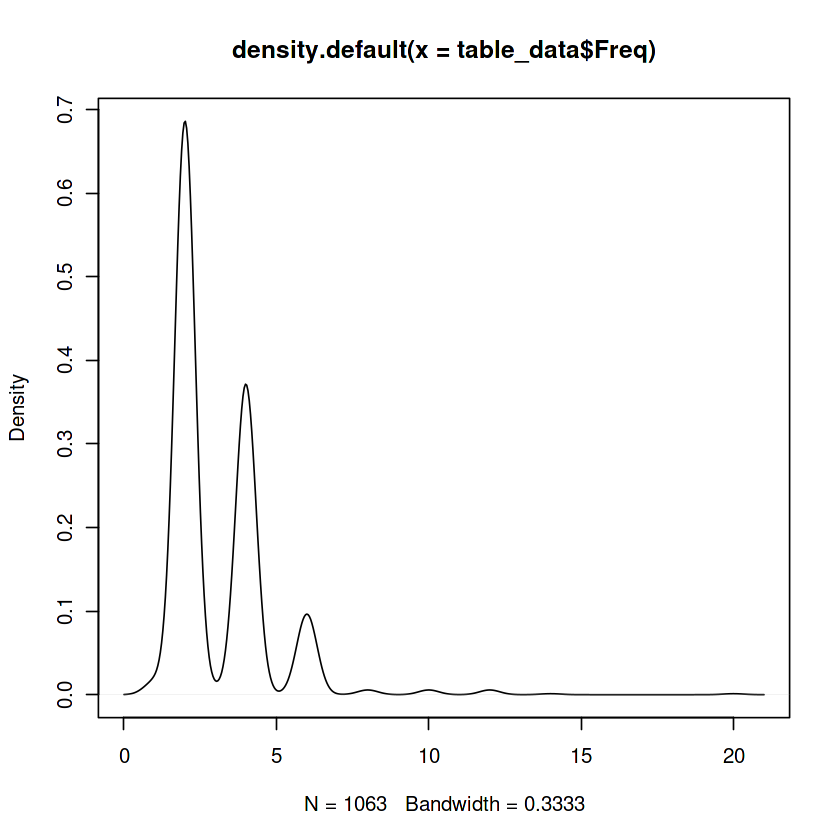

In [22]:
d <- density(table_data$Freq) # returns the density data
plot(d) # plots the results

In [23]:
table_data <- as.data.frame(table(pt_interactions$complex_pair))

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


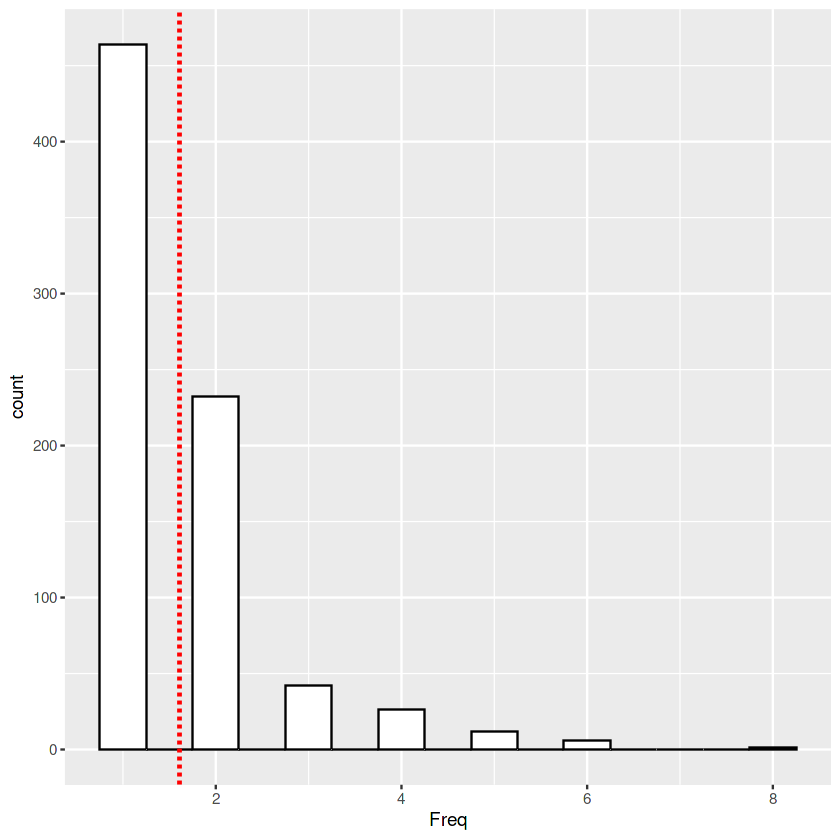

In [24]:
ggplot(table_data, aes(x=Freq)) +
    geom_histogram(binwidth=.5, colour="black", fill="white") +
    geom_vline(aes(xintercept=mean(Freq, na.rm=T)),   # Ignore NA values for mean
               color="red", linetype="dashed", size=1)
# ggsave("binaries found.jpeg")

In [25]:
# table_data <- table(pt_interactions$complex_pair)
# hist(table_data, main = "Number of binary pairs produced from complex", xlab = "# of binary originating from a single complex", ylab = "Count")

# Complexes are broken down, now we can combine with the rest of the db

In [26]:
single_components = filter(both_db, !grepl('COMPLEX', target) & !grepl('COMPLEX',source))
# remove pair column
single_components$pair <- NULL

single_components <- single_components %>%
#       dplyr::select(source_genesymbol, target_genesymbol) %>%
      dplyr::rename(Ligand=source_genesymbol, Receptor=target_genesymbol) %>%
      dplyr::mutate(complex_pair = NA)

In [27]:
single_components$Pair.Name <- paste(single_components$Ligand, single_components$Receptor, sep="_")

In [28]:
# switch column order
single_components <- data.frame(Pair.Name = single_components$Pair.Name, single_components[, !(names(single_components) %in% "Pair.Name")])

In [29]:
pt_interactions$target_genesymbol  <- NULL
pt_interactions$source_genesymbol  <- NULL

In [30]:
#merge the single ones, with complexes componenets that are detected via PT_DB
complete <- rbind(single_components, pt_interactions)
# drop duplicates, keep the last as it marks the complexes
complete <- complete[ !duplicated(complete[, "Pair.Name"], fromLast=T),]

# Gene Descriptions

We use mygene library to get the gene descriptions

In [31]:
library(mygene)

Loading required package: GenomicFeatures

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:dplyr’:

    first, rename


The following object is masked from ‘package:tidyr’:

    expand



In [32]:
# map_gene_descriptions function:
# 1. maps gene symbols to gene descriptions using the queryMany function
# 2. maps the protein descriptions to the dataset
# 3. reorders columns and renames columns

map_gene_descriptions <- function(complete) {
    # get gene symbols
    gene_symbols <- unique(c(complete$source,complete$target))
    
    prot_descriptions <- queryMany(gene_symbols, scopes = "symbol", 
                              fields = c("name"), 
                              species = "human", as_dataframe = "True")
    
    prot_descriptions <- as.data.frame(prot_descriptions)
    
    #map protein descriptions to complete set

    for (x in 1:nrow(complete)) {
        ligand_symbol=complete[x,]$source
        receptor_symbol=complete[x,]$target
        ligand_description=filter(prot_descriptions, query==ligand_symbol)$name
        receptor_description=filter(prot_descriptions, query==receptor_symbol)$name
        lig_id=filter(anno_raw, genesymbol==ligand_symbol)$uniprot[1]
        rec_id=filter(anno_raw, genesymbol==receptor_symbol)$uniprot[1]

        if (ligand_symbol=="PIK3CD-AS1") {
          lig_id <- "O00329"
        }

    #     if (is.null(receptor_description)) {
    #       receptor_description <- "NA"
    #     }


        complete[x, "ligand.name"] = ligand_description[1]
        complete[x, "receptor.name"] = receptor_description[1]
        complete[x, "partner_a"] = lig_id
        complete[x, "partner_b"] = rec_id
    }
    
#     #reorder columns
#     complete <- complete[, c("pair", "source", "ligand.name", "target", "receptor.name", "complex_pair",
#                              "partner_a","partner_b")]
#     #rename column names
#     names(complete) <- c("Pair.Name", "Ligand", "Ligand.Name", "Receptor", "Receptor.Name", "complex_pair",
#                         "partner_a","partner_b")
    
    return(complete)
}

In [33]:
gene_symbols <- unique(c(complete$Ligand,complete$Receptor))

prot_descriptions <- queryMany(gene_symbols, scopes = "symbol", 
                          fields = c("name"), 
                          species = "human", as_dataframe = "True")

prot_descriptions <- as.data.frame(prot_descriptions)

#map protein descriptions to complete set

for (x in 1:nrow(complete)) {
    ligand_symbol=complete[x,]$Ligand
    receptor_symbol=complete[x,]$Receptor
    ligand_description=filter(prot_descriptions, query==ligand_symbol)$name
    receptor_description=filter(prot_descriptions, query==receptor_symbol)$name
    lig_id=filter(anno_raw, genesymbol==ligand_symbol)$uniprot[1]
    rec_id=filter(anno_raw, genesymbol==receptor_symbol)$uniprot[1]

    if (ligand_symbol=="PIK3CD-AS1") {
      lig_id <- "O00329"
    }

#     if (is.null(receptor_description)) {
#       receptor_description <- "NA"
#     }


    complete[x, "Ligand.Name"] = ligand_description[1]
    complete[x, "Receptor.Name"] = receptor_description[1]
#     complete[x, "partner_a"] = lig_id
#     complete[x, "partner_b"] = rec_id
    }

Querying chunk 1

Querying chunk 2

Querying chunk 3



Finished
Pass returnall=TRUE to return lists of duplicate or missing query terms.


In [34]:
#reorder columns

desired_order <- c("Pair.Name", "Ligand", "Ligand.Name", "Receptor", "Receptor.Name", "complex_pair")

remaining_cols <- setdiff(names(complete), desired_order)
final_order <- c(desired_order, remaining_cols)

# Reorder the dataframe columns
complete <- complete[, final_order]

In [35]:
c <- complete

In [36]:
filter(complete,Ligand=="PIK3CD-AS1")

Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,source,target,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>
PIK3CD-AS1_LY6G6C,PIK3CD-AS1,PIK3CD antisense RNA 1,LY6G6C,lymphocyte antigen 6 family member G6C,NA,Q5SR53,O95867,1,0,0,0,0,0,Fantom5_LRdb;LRdb;iTALK,NA,0,0,2,LR
PIK3CD-AS1_SLC16A4,PIK3CD-AS1,PIK3CD antisense RNA 1,SLC16A4,solute carrier family 16 member 4,NA,Q5SR53,O15374,1,0,0,0,0,0,Fantom5_LRdb;LRdb;iTALK,NA,0,0,2,LR


In [37]:
complete$Ligand <- str_replace(complete$Ligand, "PIK3CD-AS1", "PIK3CD")
complete$Pair.Name <- paste(complete$Ligand, complete$Receptor, sep="_")
complete$dup <- paste(complete$Receptor, complete$Ligand, sep="_")

# Annotation of components

The Omnipath Intercell annotation database is imported and used to annotate each component. If at least two databases categorize a component as a ligand or receptor, it is annotated as such. If not, we check other possible categories such as extracellular matrix, secreted, and transmembrane. Below is the list of resources used to annotote.

In [38]:
# This function is to annotate the components from the PPI network with their parent category
# The input of this function is a df with columns of "genesymbol", "score", "parent"
# The output of this function is a df with columns of "genesymbol", "score", "parent"
# This function is used to annotate the components from the PPI network with their parent category

annotate_components <- function(components) {
    #create a df to store annotation
    df <- data.frame(genesymbol = character(length(components)), score = numeric(length(components)),
                     parent = character(length(components)), stringsAsFactors = FALSE)
    
    # Check if the components are categorized as ligands or receptors
    for (x in 1:length(components)) {
    #     maxvalue=max(filter(anno, uniprot==components[x])$consensus_score)
        genename <- components[x]
        parent_score <- sort(table(filter(anno_lig, genesymbol==components[x])$parent), decreasing = T, na.last = T)[1]
        parent_category <- names(parent_score)

        if (is.null(parent_category)) {
          parent_category <- "NA"
          parent_score <- 0
        }

        df[x, "genesymbol"] <- genename
        df[x, "score"] <- parent_score
        df[x, "parent"] <- parent_category

    #     df$genesymbol[x] <- genename
    #     df$score[x] <- parent_score
    #     df$parent[x] <- parent_category
    }
    
    # If a component is not classified as a ligand or receptor, we may consider other categories such as 
    # extracellular matrix, secreted, and transmembrane.# annotated others such as secreted, ecm etc

    df_na <- filter(df, parent=="NA")$genesymbol

    for (x in 1:length(df_na)) {
    #     maxvalue=max(filter(anno, uniprot==components[x])$consensus_score)
        genesymbol <- df_na[x]
        parent_score <- sort(table(filter(anno_raw, genesymbol==df_na[x])$parent), decreasing = T, na.last = T)[1]
        parent_category <- names(parent_score)

        df <- df %>% mutate(parent = ifelse(genesymbol == df_na[x], parent_category, parent))
        df <- df %>% mutate(score = ifelse(genesymbol == df_na[x], parent_score, score))

    }
    
    # replace ecm and secreted with ligand
    df$parent <- replace(df$parent, df$parent == "ecm", "ligand")
    df$parent <- replace(df$parent, df$parent == "secreted", "ligand")
    
    return(df)

}

In [39]:
components <- unique(c(complete$Ligand, complete$Receptor))

In [40]:
annotation <- annotate_components(components)

In [41]:
unique(annotation$parent)

[1] "intracellular"    "ligand"           "receptor"         "transmembrane"   
 [5] "cell_surface"     "ecm_regulator"    "cell_adhesion"    "gap_junction"    
 [9] "plasma_membrane"  "ligand_regulator"

In [42]:
#TRUE LR genespace
true_LR_anno <- filter(annotation, parent == "receptor" | parent == "ligand")
# true_LR_genespace <- true_LR_anno$genesymbol

In [43]:
annotation[annotation$genesymbol=="BMPR1B",]

,genesymbol,score,parent
,<chr>,<dbl>,<chr>
1211,BMPR1B,20,receptor


In [44]:
adhesive_genespace <- filter(annotation, !genesymbol %in% true_LR_anno$genesymbol)

In [45]:
ligands <- filter(true_LR_anno, parent=="ligand")$genesymbol
receptors <- filter(true_LR_anno, parent=="receptor")$genesymbol

In [46]:
# Filter the LR pairs that are not in the correct direction
# Exclude the pairs if the swapped (correct direction) counterparts exist in the database

LR_fix_dir <- complete %>% 
  filter(Ligand %in% receptors & Receptor %in% ligands) #%>% 
  #anti_join(complete, by = c("dup" = "Pair.Name"))
#     filter(!dup %in% complete$Pair.Name)

In [47]:
# drop abpve
complete <- filter(complete, !Pair.Name %in% LR_fix_dir$Pair.Name)

In [48]:
7415 - nrow(complete) == nrow(LR_fix_dir)

[1] TRUE

In [49]:
head(LR_fix_dir)

,Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,source,target,is_directed,is_stimulation,⋯,consensus_direction,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,dup
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>
1,NOTCH1_JAG2,NOTCH1,notch receptor 1,JAG2,jagged canonical Notch ligand 2,NA,P46531,Q9Y219,1,0,⋯,0,0,0,Baccin2019;CellCall;HPRD;NetPath;Ramilowski2015_Baccin2019;SPIKE,HPRD:11006133;NetPath:11006133;SPIKE:15358736,3,2,5,LR,JAG2_NOTCH1
2,NOTCH1_DLL1,NOTCH1,notch receptor 1,DLL1,delta like canonical Notch ligand 1,NA,P46531,O00548,1,1,⋯,0,0,0,Baccin2019;CellCall;HPRD;NetPath;Ramilowski2015_Baccin2019;SPIKE;SignaLink3;Wang,Baccin2019:11006133;HPRD:11006133;NetPath:11006133;SPIKE:11006133;SPIKE:15358736;SPIKE:17537801;SignaLink3:21985982,7,4,7,LR,DLL1_NOTCH1
3,NOTCH1_JAG1,NOTCH1,notch receptor 1,JAG1,jagged canonical Notch ligand 1,NA,P46531,P78504,1,1,⋯,0,0,0,Baccin2019;BioGRID;CellCall;DIP;HPMR;HPRD;IntAct;Kirouac2010;Lit-BM-17;NetPath;Ramilowski2015_Baccin2019;SPIKE;SignaLink3;Wang,Baccin2019:11006133;BioGRID:11006133;DIP:18660822;HPMR:7697721;HPRD:11006133;IntAct:18660822;IntAct:23086448;Lit-BM-17:11006133;Lit-BM-17:18660822;Lit-BM-17:21820430;NetPath:11006133;SPIKE:11006133;SPIKE:16713569;SPIKE:17537801;SPIKE:18495817;SignaLink3:22390640,16,9,13,both,JAG1_NOTCH1
4,SFRP1_WNT4,SFRP1,secreted frizzled related protein 1,WNT4,Wnt family member 4,NA,Q8N474,P56705,1,1,⋯,1,1,0,CancerCellMap;CellChatDB-cofactors;HPRD;NetPath;SIGNOR;SPIKE;SignaLink3;Wang,CancerCellMap:11287180;HPRD:11287180;NetPath:11287180;SIGNOR:11287180;SPIKE:11287180;SignaLink3:11287180;SignaLink3:18988627;SignaLink3:23331499,8,3,8,LR,WNT4_SFRP1
5,SFRP1_WNT2,SFRP1,secreted frizzled related protein 1,WNT2,Wnt family member 2,NA,Q8N474,P09544,1,0,⋯,1,0,1,CellChatDB-cofactors;HPRD;NetPath;SPIKE;Wang,HPRD:10347172;NetPath:10347172;SPIKE:10347172,3,1,5,LR,WNT2_SFRP1
6,SFRP1_WNT1,SFRP1,secreted frizzled related protein 1,WNT1,Wnt family member 1,NA,Q8N474,P04628,1,1,⋯,1,1,0,CancerCellMap;CellChatDB-cofactors;HPRD;NetPath;SIGNOR;SPIKE;SignaLink3;Wang,CancerCellMap:10523516;HPRD:10347172;NetPath:10347172;NetPath:10523516;SIGNOR:10347172;SIGNOR:10523516;SPIKE:10347172;SignaLink3:10347172;SignaLink3:10523516;SignaLink3:18988627;SignaLink3:21071413;SignaLink3:23331499,12,5,8,LR,WNT1_SFRP1


In [50]:
colnames(LR_fix_dir)

[1] "Pair.Name"             "Ligand"                "Ligand.Name"          
 [4] "Receptor"              "Receptor.Name"         "complex_pair"         
 [7] "source"                "target"                "is_directed"          
[10] "is_stimulation"        "is_inhibition"         "consensus_direction"  
[13] "consensus_stimulation" "consensus_inhibition"  "sources"              
[16] "references"            "curation_effort"       "n_references"         
[19] "n_resources"           "annotation_strategy"   "dup"

In [51]:
#fix the directions

# Swap values in Ligand and Receptor columns
temp <- LR_fix_dir$Ligand
LR_fix_dir$Ligand <- LR_fix_dir$Receptor
LR_fix_dir$Receptor <- temp

# Swap values in Ligand.Name and Receptor.Name columns
temp <- LR_fix_dir$Ligand.Name
LR_fix_dir$Ligand.Name <- LR_fix_dir$Receptor.Name
LR_fix_dir$Receptor.Name <- temp

# Swap values in source and target columns
temp <- LR_fix_dir$source
LR_fix_dir$source <- LR_fix_dir$target
LR_fix_dir$target <- temp

rm(temp)


LR_fix_dir["Pair.Name"] <- paste(LR_fix_dir$Ligand, LR_fix_dir$Receptor, sep="_")
LR_fix_dir["dup"] <- paste(LR_fix_dir$Receptor, LR_fix_dir$Ligand, sep="_")

In [52]:
# these are the list of interactions that are strictly in LR direction
true_LR_DB <- complete %>% filter(Ligand %in% ligands & Receptor %in% receptors)

In [53]:
#drop above, should be only adhesive
complete <- filter(complete, !Pair.Name %in% true_LR_DB$Pair.Name)

In [54]:
# after fix, it might be duplicated
LR_fix_dir <- LR_fix_dir[!LR_fix_dir$Pair.Name %in% true_LR_DB$Pair.Name,]

In [55]:
true_LR_DB["True_LR"]=TRUE
LR_fix_dir["True_LR"]=TRUE
true_LR_DB <- rbind(true_LR_DB,LR_fix_dir)

In [56]:
adhesive_DB <- filter(complete, !Pair.Name %in% true_LR_DB$Pair.Name)

In [57]:
adhesive_DB["True_LR"]=FALSE

In [58]:
nrow(true_LR_DB) + nrow (adhesive_DB)

[1] 7112

In [59]:
reversed <- adhesive_DB[adhesive_DB$dup %in% adhesive_DB$Pair.Name,  ]

In [60]:
# check if any of them in true_LR, it should not
filter(reversed, dup %in% true_LR_DB$Pair.Name)

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,source,target,is_directed,is_stimulation,⋯,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,dup,True_LR
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<lgl>


In [61]:
nrow(adhesive_DB)

[1] 2955

In [62]:
# remove the subsetted partition from the original df
adhesive_DB <- adhesive_DB[!adhesive_DB$Pair.Name %in% reversed$Pair.Name,  ]

In [63]:
2955-nrow(reversed) == nrow(adhesive_DB)

[1] TRUE

In [64]:
2955-nrow(reversed)

[1] 2613

In [65]:
# remove the subsetted partition from the original df
adhesive_DB <- adhesive_DB[!adhesive_DB$Pair.Name %in% reversed$Pair.Name,  ]

In [66]:
# Extract all the unique proteins/genes from the subset_lr data frame that have "plexin",
# "neuroligin" or "ADAM" in their Receptor.Name column
# these will be corrected as ligands

plexin_family <- as.vector(reversed[grep("plexin", reversed$Receptor.Name), ]$Receptor)

neuroligin_family <- as.vector(reversed[grep("neuroligin", reversed$Receptor.Name), ]$Receptor)

adam_family <- as.vector(reversed[grep("ADAM", reversed$Receptor.Name), ]$Receptor)

#extract receptors that has annotation of "receptor" under Ligand.Name
receptor_anno <- as.vector(reversed[grep("receptor", reversed$Ligand.Name), ]$Ligand)

In [67]:
ligand <- c("AGRN", "BMP2", "BMP4", "VTCN1", "CD244", "CD38", "GAS6", "GDNF", "GUCA2A", 
"HHLA2", "IHH", "PSEN1", "NLGN", "NRTN", "RPH3A", "SHH","FLT3LG")

receptor <- c("CD2", "CD27", "CD80", "CD86", "SELL", "CD44", "CD81", "CD8A", "CLEC1B", 
"GLG1", "TYROBP", "FLT3", "ERBB2", "EGFR", "IL1R1", "IL1RAP", "KDR", "NRP1")

In [68]:
# Combine the additional ligands with the plexin, neuroligin, and ADAM families into a vector called ligand
ligand <- unique(c(ligand,plexin_family,neuroligin_family,adam_family))
receptor <- unique(c(receptor,receptor_anno))

In [69]:
filter(reversed, dup %in% true_LR_DB$Pair.Name)

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,source,target,is_directed,is_stimulation,⋯,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,dup,True_LR
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<lgl>


In [70]:
nrow(reversed)

[1] 342

In [71]:
# Subset the subset_lr data frame to only include rows where the consensus_direction column is 1
dir <- reversed %>% filter(Pair.Name %in% reversed$dup & consensus_direction == 1)

In [72]:
reversed %>% filter(Pair.Name %in% reversed$dup & consensus_direction == 1)

Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,source,target,is_directed,is_stimulation,⋯,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,dup,True_LR
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<lgl>
TIMD4_HAVCR1,TIMD4,T cell immunoglobulin and mucin domain containing 4,HAVCR1,hepatitis A virus cellular receptor 1,NA,Q96H15,Q96D42,1,1,⋯,1,0,SPIKE;Wojtowicz2020;connectomeDB2020,SPIKE:15793576;connectomeDB2020:28949386,3,2,3,both,HAVCR1_TIMD4,FALSE
CD80_CD28,CD80,CD80 molecule,CD28,CD28 molecule,NA,P33681,P10747,1,1,⋯,1,0,BioGRID;CellChatDB;CellPhoneDB_Cellinker;Cellinker;DIP;HPRD;ICELLNET;KEGG-MEDICUS;LRdb;Lit-BM-17;NetPath;SPIKE;Wang;Wojtowicz2020;connectomeDB2020;iTALK,BioGRID:1847722;CellChatDB:23954143;Cellinker:21530327;Cellinker:23954143;DIP:1847722;DIP:2164219;DIP:7964482;HPRD:7545666;ICELLNET:7545666;LRdb:22437870;Lit-BM-17:1847722;Lit-BM-17:2164219;Lit-BM-17:21982860;Lit-BM-17:7545666;Lit-BM-17:7964482;NetPath:2164219;SPIKE:15610849;SPIKE:21487479;connectomeDB2020:7545666,19,10,15,both,CD28_CD80,FALSE
CD86_CD28,CD86,CD86 molecule,CD28,CD28 molecule,NA,P42081,P10747,1,1,⋯,1,0,Baccin2019;CellChatDB;CellPhoneDB_Cellinker;CellTalkDB;Cellinker;DIP;HPRD;ICELLNET;KEGG-MEDICUS;LRdb;SPIKE;Wang;Wojtowicz2020;connectomeDB2020;iTALK,CellChatDB:23954143;CellTalkDB:23954143;Cellinker:21530327;Cellinker:23954143;DIP:21931534;HPRD:11021528;HPRD:7513726;ICELLNET:18205792;LRdb:22437870;SPIKE:11021528;SPIKE:21487479;connectomeDB2020:23954143,12,8,14,both,CD28_CD86,FALSE
PSEN1_NCSTN,PSEN1,presenilin 1,NCSTN,nicastrin,NA,P49768,Q92542,1,1,⋯,1,0,CellTalkDB;Cellinker;EMBRACE;Fantom5_LRdb;HPMR;HPMR_Cellinker;HPMR_LRdb;HPMR_talklr;HPRD;HPRD_LRdb;HPRD_talklr;IntAct;LRdb;Ramilowski2015;STRING_talklr;Wang;connectomeDB2020;iTALK;talklr,CellTalkDB:10993067;Cellinker:10993067;Cellinker:12603837;HPMR:10993067;HPRD:10993067;HPRD:12603837;IntAct:18201567;LRdb:10993067;LRdb:13;connectomeDB2020:10993067;connectomeDB2020:12603837,11,4,12,both,NCSTN_PSEN1,FALSE
SELPLG_SELP,SELPLG,selectin P ligand,SELP,selectin P,NA,Q14242,P16109,1,1,⋯,1,0,CellChatDB;CellPhoneDB_Cellinker;CellTalkDB;Cellinker;DIP;Fantom5_LRdb;Guide2Pharma;HPMR;HPMR_Cellinker;HPMR_LRdb;HPMR_talklr;HPRD;HPRD_LRdb;HPRD_talklr;InnateDB;IntAct;LRdb;Lit-BM-17;Ramilowski2015;SIGNOR;STRING_talklr;Wang;connectomeDB2020;iTALK;scConnect;talklr,CellChatDB:19118202;CellChatDB:9829984;CellTalkDB:12393589;Cellinker:10713099;Cellinker:19118202;Cellinker:9128259;Cellinker:9129046;Cellinker:9829984;DIP:19118202;Guide2Pharma:9829984;HPMR:9129046;HPRD:10713099;HPRD:17064811;HPRD:9128259;InnateDB:11081633;IntAct:11081633;IntAct:19118202;IntAct:26627825;LRdb:10713099;LRdb:17064811;LRdb:9128259;LRdb:9129046;Lit-BM-17:10713099;Lit-BM-17:11081633;Lit-BM-17:19118202;SIGNOR:23994464;SIGNOR:9129046;connectomeDB2020:10713099;connectomeDB2020:17064811;connectomeDB2020:9128259;connectomeDB2020:9129046;scConnect:9829984,32,10,18,both,SELP_SELPLG,FALSE
RTN4_LINGO1,RTN4,reticulon 4,LINGO1,leucine rich repeat and Ig domain containing 1,NA,Q9NQC3,Q96FE5,1,1,⋯,1,0,Baccin2019;CellTalkDB;EMBRACE;Fantom5_LRdb;HPMR_LRdb;HPMR_talklr;LRdb;Ramilowski2015;Ramilowski2015_Baccin2019;SIGNOR;Wang;connectomeDB2020;iTALK;talklr,Baccin2019:15694322;CellTalkDB:15694322;LRdb:15694322;SIGNOR:15694321;connectomeDB2020:15694322,5,2,10,both,LINGO1_RTN4,FALSE
NTNG1_LRRC4C,NTNG1,netrin G1,LRRC4C,leucine rich repeat containing 4C,NA,Q9Y2I2,Q9HCJ2,1,1,⋯,1,0,Baccin2019;BioGRID;CellTalkDB;EMBRACE;Fantom5_LRdb;HPMR;HPMR_LRdb;HPMR_talklr;HPRD;HPRD_LRdb;HPRD_talklr;IntAct;LRdb;Lit-BM-17;Ramilowski2015;Ramilowski2015_Baccin2019;SIGNOR;STRING_talklr;Wang;connectomeDB2020;iTALK;talklr,Baccin2019:1459544314595440;BioGRID:21946559;CellTalkDB:14595443;HPMR:14595443;HPRD:14595443;IntAct:21946559;LRdb:14595443;Lit-BM-17:14595443;Lit-BM-17:21946559;SIGNOR:19467332;connectomeDB2020:14595443,11,4,15,both

In [73]:
reversed$dup = paste(reversed$Receptor, reversed$Ligand, sep="_")

In [74]:
# pre_dir = read.csv("reversed_dir.csv")

In [75]:
# pre_reversed = read.csv("reversed_previous.csv")

In [76]:
dir = reversed[reversed$Pair.Name %in% reversed$dup & reversed$consensus_direction == 1, ]

In [77]:
# not_in = pre_dir[!pre_dir$Pair.Name %in% x$Pair.Name,]

In [78]:
# pre_dir[pre_dir$Pair.Name=="CD74_CXCR4",]

In [79]:
# reversed[reversed$Pair.Name=="CD74_CXCR4",]

In [80]:
# reversed[reversed$Pair.Name=="CD74_CXCR4",]$consensus_direction

In [81]:
# non_curated[non_curated$pair=="CD74_CXCR4",]

Difference is coming from complexes molecules. Pair of complex molecule can be found in the non_curated or curated_db. and the pair annotation for direction might differ. In this case, we are taking the complex molecule annotations.

example: CD74_CXCR4 pair is not in dir. 

check
```R
reversed[reversed$Pair.Name=="CD74_CXCR4",]$consensus_direction
```
and
```R
non_curated[non_curated$pair=="CD74_CXCR4",]
```

In [82]:
# Subset the subset_lr data frame to only include rows where the consensus_direction column is 0
no_dir <- reversed %>% filter(Pair.Name %in% reversed$dup & consensus_direction == 0)

In [83]:
#no_dir 291

In [84]:
nrow(no_dir) + nrow(dir)

[1] 342

In [85]:
"CD80_CTLA4" %in% dir$Pair.Name

[1] TRUE

In [86]:
"CTLA4_CD80" %in% no_dir$Pair.Name

[1] TRUE

In [87]:
# Remove rows from no_dir where the pair is already present in dir
in_dir <- dir[dir$dup %in% no_dir$Pair.Name,] 
no_dir <- no_dir[!no_dir$dup %in% in_dir$Pair.Name,  ] #removal of those in dir below is rm of nodir

In [88]:
dir <- dir[!dir$Pair.Name %in% in_dir$Pair.Name,]

In [89]:
nrow(in_dir) + nrow(dir) + nrow(no_dir)

[1] 299

In [90]:
"CD80_CTLA4" %in% dir$Pair.Name

[1] FALSE

In [91]:
"CTLA4_CD80" %in% no_dir$Pair.Name

[1] FALSE

In [92]:
"CD80_CTLA4" %in% in_dir$Pair.Name

[1] TRUE

In [93]:
nrow(no_dir)

[1] 248

In [94]:
# remove the interactions where receptor is annotated as ligand
wrong_lig <- no_dir[no_dir$Receptor %in% ligand,]
correct_lig <- no_dir[no_dir$dup %in% wrong_lig$Pair.Name,]
no_dir <- no_dir[!no_dir$Pair.Name %in% c(wrong_lig$Pair.Name, correct_lig$Pair.Name),]

In [95]:
wrong_rec <- no_dir[no_dir$Ligand %in% receptor,]
wrong_rec <- wrong_rec[!wrong_rec$Pair.Name %in% wrong_rec$dup,]

In [96]:
# remove the interactions where receptor is annotated as ligand
wrong_rec <- no_dir[no_dir$Ligand %in% receptor,]
wrong_rec <- wrong_rec[!wrong_rec$Pair.Name %in% wrong_rec$dup,]
correct_rec <- no_dir[no_dir$dup %in% wrong_rec$Pair.Name,]
no_dir <- no_dir[!no_dir$Pair.Name %in% c(wrong_rec$Pair.Name, correct_rec$Pair.Name),]

In [97]:
nrow(no_dir)

[1] 114

In [98]:
# Function to lexographically sort the gene pairs
sort_pairs <- function(pair) {
  parts <- strsplit(pair, "_")[[1]]
  sorted_parts <- sort(parts)
  return(paste(sorted_parts, collapse = "_"))
}

In [99]:
no_dir <- no_dir[order( no_dir[,2], no_dir[,4] ),]

In [100]:
no_dir$sort <- sapply(no_dir$Pair.Name, sort_pairs)

In [103]:
no_dir <- no_dir %>% distinct(sort, .keep_all = TRUE)

In [104]:
no_dir$sort <- NULL

In [106]:
# some of the swapped duplicates are both directional, for this one, we also keep the lexograph order
dir <- dir[order( dir[,2], dir[,4] ),]

dir$sort <- sapply(dir$Pair.Name, sort_pairs)

dir <- dir %>% distinct(sort, .keep_all = TRUE)

dir$sort <- NULL

In [108]:
"IL1RAP_IL1R1" %in% dir$Pair.Name

[1] FALSE

In [109]:
"IL1R1_IL1RAP" %in% dir$Pair.Name

[1] TRUE

In [110]:
# dir <- dir[duplicated(dir$Pair.Name, fromLast = TRUE),]
# dir$Pair.Name <- paste(dir$Ligand, dir$Receptor, sep="_")

In [111]:
# Combine the dir and no_dir_df data frames
subset_lr <- rbind(dir,no_dir,in_dir,correct_lig,correct_rec)

In [112]:
subset_lr["True_LR"] <- FALSE

In [113]:
# Add the remaining rows of LR_database to subset_lr
adhesive_DB <- rbind(subset_lr,adhesive_DB)

In [114]:
LR_database <- rbind(true_LR_DB, adhesive_DB)

In [115]:
LR_database$Pair.Name <- paste(LR_database$Ligand, LR_database$Receptor, sep = "_")
LR_database$dup <- paste(LR_database$Receptor, LR_database$Ligand, sep = "_")

In [116]:
LR_database[LR_database$Pair.Name %in% LR_database$dup,]

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,source,target,is_directed,is_stimulation,⋯,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,dup,True_LR
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<lgl>


In [117]:
colnames(LR_database)

[1] "Pair.Name"             "Ligand"                "Ligand.Name"          
 [4] "Receptor"              "Receptor.Name"         "complex_pair"         
 [7] "source"                "target"                "is_directed"          
[10] "is_stimulation"        "is_inhibition"         "consensus_direction"  
[13] "consensus_stimulation" "consensus_inhibition"  "sources"              
[16] "references"            "curation_effort"       "n_references"         
[19] "n_resources"           "annotation_strategy"   "dup"                  
[22] "True_LR"

In [118]:
LR_database$dup <- NULL

In [121]:
post_LR <- LR_database

In [122]:
library(community)

In [123]:
data(LR_database)

In [127]:
LR_database[!LR_database$Pair.Name %in% post_LR$Pair.Name,]

,Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b,source,target,⋯,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,db,True_LR
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<lgl>
21000,ACVRL1_ACVR2A,ACVRL1,activin A receptor like type 1,ACVR2A,activin A receptor type 2A,BMP10_ACVR2A_ACVRL1,P37023,P27037,P37023,P27037,⋯,0,0,Cellinker;DIP;HPRD;Wang,Cellinker:30761306;DIP:10187774;DIP:8612709;HPRD:10187774,4,3,4,LR,both,FALSE
11100,BMPR1B_AMHR2,BMPR1B,bone morphogenetic protein receptor type 1B,AMHR2,anti-Mullerian hormone receptor type 2,AMH_AMHR2_BMPR1B,O00238,Q16671,P03971,COMPLEX:O00238_Q16671,⋯,0,0,CellPhoneDB;CellPhoneDB_Cellinker;Cellinker,CellPhoneDB:22710174;Cellinker:22710174,2,1,2,LR,both,FALSE
13111,ERBB4_EGFR,ERBB4,erb-b2 receptor tyrosine kinase 4,EGFR,epidermal growth factor receptor,EGF_EGFR_ERBB4,Q15303,P00533,P01133,COMPLEX:P00533_Q15303,⋯,0,0,Cellinker,Cellinker:24269963,1,1,1,LR,both,FALSE
14911,LCK_CD8B,LCK,"LCK proto-oncogene, Src family tyrosine kinase",CD8B,CD8 subunit beta,LCK_CD8A_CD8B,P06239,P10966,P06239,COMPLEX:P01732_P10966,⋯,0,0,CellChatDB;CellPhoneDB;Cellinker,CellChatDB:25427562;Cellinker:25427562,2,1,3,LR,both,FALSE
5112,SEMA4D_PLXNB1,SEMA4D,semaphorin 4D,PLXNB1,plexin B1,SEMA4D_MET_PLXNB1,Q92854,O43157,Q92854,O43157,⋯,1,0,Baccin2019;CellChatDB;CellPhoneDB_Cellinker;CellTalkDB;Cellinker;DIP;EMBRACE;Fantom5_LRdb;HPMR;HPMR_Cellinker;HPMR_LRdb;HPMR_talklr;HPRD;HPRD_LRdb;HPRD_talklr;ICELLNET;IntAct;LRdb;Ramilowski2015;Ramilowski2015_Baccin2019;SIGNOR;STRING_talklr;Wang;connectomeDB2020;iTALK;talklr,Baccin2019:10520995;Baccin2019:11937491;Baccin2019:12198496;CellChatDB:27533782;CellTalkDB:10520995;Cellinker:10520995;Cellinker:11937491;Cellinker:12198496;Cellinker:24043639;Cellinker:27533782;DIP:20877282;HPMR:10520995;HPRD:11937491;ICELLNET:11245885;IntAct:20877282;LRdb:10520995;LRdb:11937491;LRdb:12198496;SIGNOR:12198496;connectomeDB2020:10520995;connectomeDB2020:11937491;connectomeDB2020:12198496,22,7,17,LR,both,FALSE
5310,TGFBR2_TGFBR1,TGFBR2,transforming growth factor beta receptor 2,TGFBR1,transforming growth factor beta receptor 1,TGFB1_TGFBR1_TGFBR2,P37173,P36897,P01137,COMPLEX:P36897_P37173,⋯,1,0,CellChatDB;CellPhoneDB;ICELLNET;KEGG-MEDICUS,ICELLNET:1333888;ICELLNET:7693660;ICELLNET:8242743,3,3,4,LR,both,FALSE


In [129]:
post_LR[!post_LR$Pair.Name %in% LR_database$Pair.Name,]

,Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,source,target,is_directed,is_stimulation,⋯,consensus_direction,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,True_LR
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<lgl>
4101,TGFBR1_TGFBR2,TGFBR1,transforming growth factor beta receptor 1,TGFBR2,transforming growth factor beta receptor 2,TGFB1_TGFBR1_TGFBR2,P01137,COMPLEX:P36897_P37173,1,1,⋯,1,1,0,CellChatDB;CellPhoneDB;ICELLNET;KEGG-MEDICUS,ICELLNET:1333888;ICELLNET:7693660;ICELLNET:8242743,3,3,4,both,FALSE
6101,ACVR2A_ACVRL1,ACVR2A,activin A receptor type 2A,ACVRL1,activin A receptor like type 1,BMP10_ACVR2A_ACVRL1,O95393,COMPLEX:P27037_P37023,1,0,⋯,0,0,0,CellChatDB;Cellinker;HPMR_Cellinker;ICELLNET,CellChatDB:25620979;CellChatDB:26893264;Cellinker:16049014;Cellinker:17068149;Cellinker:26893264;Cellinker:27252362;Cellinker:30246252;ICELLNET:17878607,8,7,3,both,FALSE
10100,AMHR2_BMPR1B,AMHR2,anti-Mullerian hormone receptor type 2,BMPR1B,bone morphogenetic protein receptor type 1B,AMH_AMHR2_BMPR1B,P03971,COMPLEX:O00238_Q16671,1,0,⋯,0,0,0,CellPhoneDB;CellPhoneDB_Cellinker;Cellinker,CellPhoneDB:22710174;Cellinker:22710174,2,1,2,both,FALSE
29100,CD8B_LCK,CD8B,CD8 subunit beta,LCK,"LCK proto-oncogene, Src family tyrosine kinase",LCK_CD8A_CD8B,P06239,COMPLEX:P01732_P10966,1,0,⋯,0,0,0,CellChatDB;CellPhoneDB;Cellinker,CellChatDB:25427562;Cellinker:25427562,2,1,3,both,FALSE
4311,EGFR_ERBB4,EGFR,epidermal growth factor receptor,ERBB4,erb-b2 receptor tyrosine kinase 4,EGF_EGFR_ERBB4,P01133,COMPLEX:P00533_Q15303,1,0,⋯,0,0,0,Cellinker,Cellinker:24269963,1,1,1,both,FALSE
28910,PLXNB1_SEMA4D,PLXNB1,plexin B1,SEMA4D,semaphorin 4D,MET_PLXNB1_SEMA4D,COMPLEX:O43157_P08581,Q92854,1,0,⋯,0,0,0,Baccin2019,Baccin2019:22189792,1,1,1,LR,FALSE


In [130]:
write.csv(post_LR, "LR_database.csv")

In [132]:
save(post_LR, "LR_database.rda")

ERROR: Error in save(post_LR, "LR_database.rda"): object ‘LR_database.rda’ not found
